## Imports

In [ ]:
import optax
import numpy as np
import functools
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from jax import random
from jax.experimental import ode
from flax.training import train_state
from sklearn.datasets import make_moons
from scipy.integrate import solve_ivp

## Swish Activation

In [ ]:
class Swish(nn.Module):

  @nn.compact
  def __call__(self, x):
    return x * jax.nn.sigmoid(x)

## Vector Field Model


In [ ]:
class MLP(nn.Module):
  input_dim: int
  time_dim: int
  hidden_dim: int

  @nn.compact
  def __call__(self, x, t):
    size = x.shape
    h = jnp.concatenate([x, t], axis = -1)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.hidden_dim)(h)
    h = Swish()(h)
    h = nn.Dense(self.input_dim)(h)
    return h.reshape(*size)


## Make Dataset

In [ ]:
def make_dataset(num_samples):
  X, _ = make_moons(n_samples = num_samples, noise = 0.1, random_state = 42)
  return np.array(X, dtype = np.float32)


## Update Step

In [ ]:
@jax.jit
def update(state, x_t, t, dx_t):

  def loss_fn(params):
    vector_field = state.apply_fn({"params": params}, x_t, t)
    loss = jnp.mean((vector_field - dx_t) ** 2)
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grad = grad_fn(state.params)
  return state.apply_gradients(grads = grad), loss


## Initialize State

In [ ]:
def create_train_state(rng, model, input_shape, time_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype=jnp.float32), jnp.ones(time_shape, dtype=jnp.float32))["params"]

  params = initialize_model(rng)
  tx = optax.adamw(learning_rate = 1e-3)

  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Sample

In [ ]:
def sample(apply_fn, params, num_samples, data_dim):
  all_samples = []
  timesteps = 2000
  samples = random.normal(random.PRNGKey(1), (num_samples, data_dim))
  all_samples.append(samples)
  dt = 1 / timesteps
  for t in jnp.linspace(1.0, 0.0, timesteps):
    time = jnp.ones((num_samples, 1)) * t
    v_t = apply_fn({"params": params}, samples, time)
    samples -= v_t * dt
    all_samples.append(samples)
  return np.stack(all_samples, axis = 0)

## Train and Generate

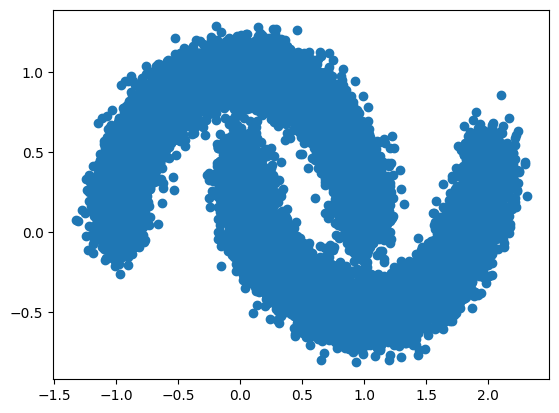

Step 0 | 20000: Loss - 1.6437197923660278
Step 500 | 20000: Loss - 1.009893774986267
Step 1000 | 20000: Loss - 1.015691876411438
Step 1500 | 20000: Loss - 0.9838476181030273
Step 2000 | 20000: Loss - 0.9924672842025757
Step 2500 | 20000: Loss - 0.9650901556015015
Step 3000 | 20000: Loss - 1.0083446502685547
Step 3500 | 20000: Loss - 1.0108238458633423
Step 4000 | 20000: Loss - 1.005846619606018
Step 4500 | 20000: Loss - 0.9763754606246948
Step 5000 | 20000: Loss - 0.9700972437858582
Step 5500 | 20000: Loss - 0.9765374660491943
Step 6000 | 20000: Loss - 0.9609094262123108
Step 6500 | 20000: Loss - 0.9690090417861938
Step 7000 | 20000: Loss - 0.9745514392852783
Step 7500 | 20000: Loss - 1.0089659690856934
Step 8000 | 20000: Loss - 0.9813269376754761
Step 8500 | 20000: Loss - 1.0213221311569214
Step 9000 | 20000: Loss - 0.9799732565879822
Step 9500 | 20000: Loss - 0.9662035703659058
Step 10000 | 20000: Loss - 0.9784944653511047
Step 10500 | 20000: Loss - 0.9520272016525269
Step 11000 | 20

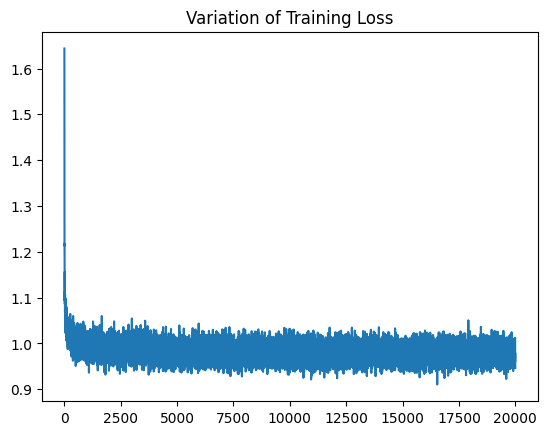

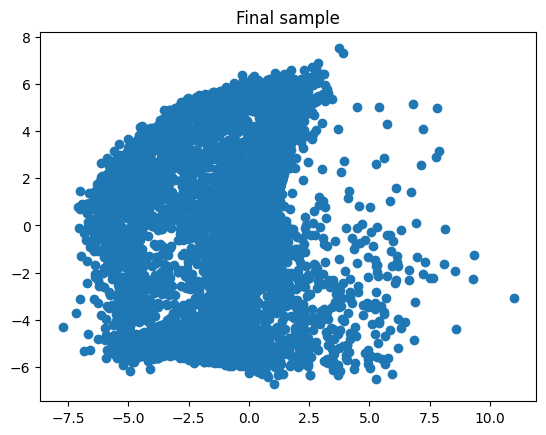

In [ ]:
def main():
  batch_size = 4096
  iterations = 20000
  hidden_dim = 512
  key = 42
  num_samples = 20000
  eval_samples = 10000
  eval_interval = 500
  batch_counter = 0

  dataset = make_dataset(num_samples)
  plt.figure()
  plt.scatter(dataset[:,0], dataset[:,-1])
  plt.show()

  data_dim = dataset.shape[-1]
  model = MLP(input_dim = data_dim, time_dim = 1, hidden_dim = hidden_dim)
  rng = random.PRNGKey(key)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng,
      model,
      input_shape = (batch_size, data_dim),
      time_shape = (batch_size, 1)
  )
  losses = []
  for step in range(iterations):
    min_size = batch_counter * batch_size
    max_size = (batch_counter + 1) * batch_size
    if max_size > num_samples:
      max_size = -1
      batch_counter = 0
    x_1 = dataset[min_size:max_size]
    rng, sub_rng = random.split(rng)
    x_0 = random.normal(rng, (batch_size, data_dim))
    t = random.uniform(sub_rng, (batch_size, 1))
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    state, loss = update(state, x_t, t, dx_t)
    losses.append(loss)
    if step % eval_interval == 0:
      print(f"Step {step} | {num_samples}: Loss - {loss}")

  plt.figure()
  plt.plot([i for i in range(0, len(losses))], losses)
  plt.title("Variation of Training Loss")
  plt.show()
  eval_samples = sample(state.apply_fn, state.params, eval_samples, data_dim)
  plt.figure()
  plt.scatter(eval_samples[-1,:,0], eval_samples[-1,:,1])
  plt.title("Final sample")
  plt.show()

if __name__ == "__main__":
  main()
